방법 1) 결측값 제거한 랜덤포레스트 테스트1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# 1) 데이터 로드 (결측값 제거된 피클 사용)
df = pd.read_pickle("diabetes_dropna.pkl")
print("데이터 로드:", df.shape)

# 2) X, y 분리
X = df.drop(columns="Outcome")  # 독립변수
y = df["Outcome"]               # 종속변수

# 3) Train/Test 분리 (클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# 4) RandomForest 파이프라인 구성
pipe = Pipeline([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 하이퍼파라미터 탐색 범위
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["sqrt", "log2"]
}

# 5) GridSearchCV로 최적 파라미터 탐색
gs = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("\n최적 파라미터:", gs.best_params_)
print("교차검증 ROC-AUC:", gs.best_score_)

# 6) 최적 모델 평가
best_model = gs.best_estimator_

# Train 성능
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]
train_acc = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

# Test 성능
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print("\n=== Train/Test Performance ===")
print(f"Train ACC: {train_acc:.3f}, Train ROC-AUC: {train_auc:.3f}")
print(f"Test  ACC: {test_acc:.3f}, Test  ROC-AUC: {test_auc:.3f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# 7) 교차검증 안정성 확인
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="roc_auc", n_jobs=-1)
print("\nCV ROC-AUC scores:", np.round(cv_scores, 3))
print("CV 평균:", round(cv_scores.mean(), 3), "│ 표준편차:", round(cv_scores.std(), 3))


데이터 로드: (532, 8)
Train: 425, Test: 107
Fitting 5 folds for each of 48 candidates, totalling 240 fits

최적 파라미터: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
교차검증 ROC-AUC: 0.8369393310863364

=== Train/Test Performance ===
Train ACC: 0.868, Train ROC-AUC: 0.956
Test  ACC: 0.785, Test  ROC-AUC: 0.865

Confusion Matrix (Test):
[[61 10]
 [13 23]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        71
           1       0.70      0.64      0.67        36

    accuracy                           0.79       107
   macro avg       0.76      0.75      0.75       107
weighted avg       0.78      0.79      0.78       107


CV ROC-AUC scores: [0.874 0.768 0.826 0.889 0.886]
CV 평균: 0.849 │ 표준편차: 0.046


훈련용 acc와 테스트 acc

방법 1) 결측값 제거한 랜덤포레스트 테스트2

데이터 로드: (532, 8)
Train: 425, Test: 107
Fitting 5 folds for each of 54 candidates, totalling 270 fits

최적 파라미터: {'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
교차검증 ROC-AUC: 0.83783380865958

=== Train/Test Performance ===
Train ACC: 0.920, Train ROC-AUC: 0.981
Test  ACC: 0.794, Test  ROC-AUC: 0.870

Confusion Matrix (Test):
[[62  9]
 [13 23]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        71
           1       0.72      0.64      0.68        36

    accuracy                           0.79       107
   macro avg       0.77      0.76      0.76       107
weighted avg       0.79      0.79      0.79       107



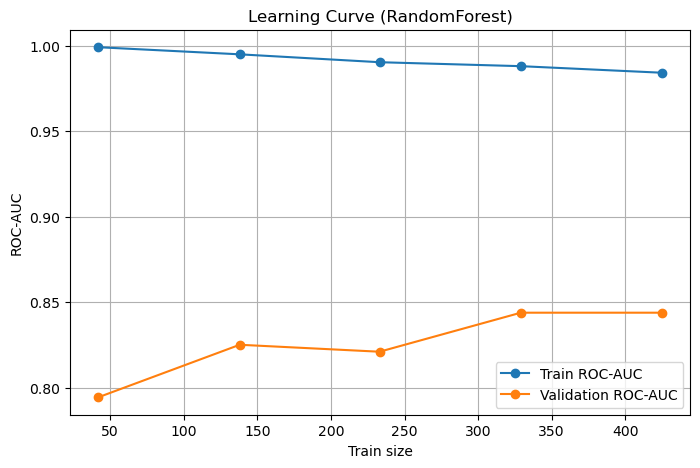

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1) 데이터 로드
df = pd.read_pickle("diabetes_dropna.pkl")
print("데이터 로드:", df.shape)

# 2) X, y 분리
X = df.drop(columns="Outcome")
y = df["Outcome"]

# 3) Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# 4) RandomForest 파이프라인
pipe = Pipeline([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 5) GridSearchCV: 과적합 완화 위해 max_depth/leaf/split 조정
param_grid = {
    "rf__n_estimators": [200],
    "rf__max_depth": [3, 5, 7],             # 트리 깊이 제한
    "rf__min_samples_split": [2, 5, 10],    # 내부 노드 분할 최소 샘플
    "rf__min_samples_leaf": [1, 2, 4],      # 리프 노드 최소 샘플
    "rf__max_features": ["sqrt", "log2"]    # 각 분할에 사용되는 변수 수                                                          
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("\n최적 파라미터:", gs.best_params_)
print("교차검증 ROC-AUC:", gs.best_score_)

# 6) 최적 모델 평가
best_model = gs.best_estimator_

y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:,1]
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

print("\n=== Train/Test Performance ===")
print(f"Train ACC: {accuracy_score(y_train, y_train_pred):.3f}, Train ROC-AUC: {roc_auc_score(y_train, y_train_proba):.3f}")
print(f"Test  ACC: {accuracy_score(y_test, y_test_pred):.3f}, Test  ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# 7) 학습곡선으로 과적합 시각화
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train ROC-AUC")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation ROC-AUC")
plt.xlabel("Train size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve (RandomForest)")
plt.legend()
plt.grid()
plt.show()


방법 1) 결측값 제거한 랜덤포레스트 테스트3

데이터 로드: (532, 8)
Train: 425, Test: 107
Fitting 5 folds for each of 36 candidates, totalling 180 fits

최적 파라미터: {'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
교차검증 ROC-AUC: 0.8371985999481464

=== Train/Test Performance ===
Train ACC: 0.826, Train ROC-AUC: 0.906
Test  ACC: 0.813, Test  ROC-AUC: 0.871

Confusion Matrix (Test):
[[67  4]
 [16 20]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        71
           1       0.83      0.56      0.67        36

    accuracy                           0.81       107
   macro avg       0.82      0.75      0.77       107
weighted avg       0.82      0.81      0.80       107



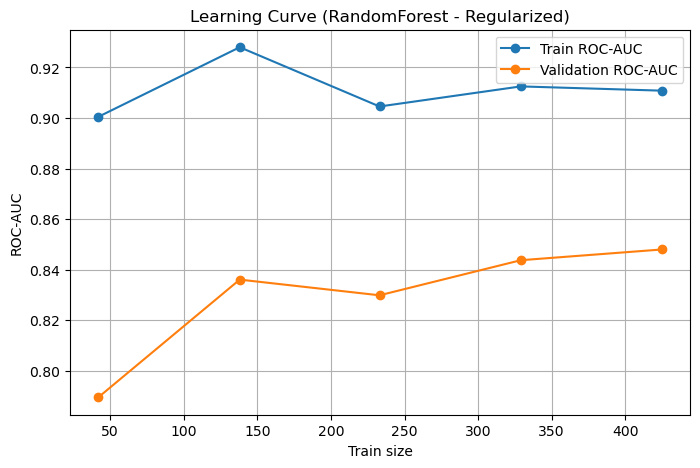

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1) 데이터 로드
df = pd.read_pickle("diabetes_dropna.pkl")
print("데이터 로드:", df.shape)

# 2) X, y 분리
X = df.drop(columns="Outcome")
y = df["Outcome"]

# 3) Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# 4) RandomForest 파이프라인
pipe = Pipeline([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 5) GridSearchCV: 과적합 완화용 파라미터
param_grid = {
    "rf__n_estimators": [200],
    "rf__max_depth": [3, 4, 5],             # 트리 깊이 제한
    "rf__min_samples_split": [5, 10],       # 내부 노드 분할 최소 샘플
    "rf__min_samples_leaf": [3, 5, 10],     # 리프 노드 최소 샘플
    "rf__max_features": ["sqrt", "log2"]    # 각 분할에 사용되는 변수 수
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("\n최적 파라미터:", gs.best_params_)
print("교차검증 ROC-AUC:", gs.best_score_)

# 6) 최적 모델 평가
best_model = gs.best_estimator_

y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:,1]
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

print("\n=== Train/Test Performance ===")
print(f"Train ACC: {accuracy_score(y_train, y_train_pred):.3f}, Train ROC-AUC: {roc_auc_score(y_train, y_train_proba):.3f}")
print(f"Test  ACC: {accuracy_score(y_test, y_test_pred):.3f}, Test  ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# 7) 학습곡선으로 과적합 시각화
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train ROC-AUC")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation ROC-AUC")
plt.xlabel("Train size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve (RandomForest - Regularized)")
plt.legend()
plt.grid()
plt.show()


방법 1-1) RandomForest와 비슷한 설정 기준으로 XGBoost 학습
- XGBoost 학습 + GridSearch + 학습곡선 시각화

데이터 로드: (532, 8)
Train: 425, Test: 107
Fitting 5 folds for each of 72 candidates, totalling 360 fits

최적 파라미터: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
교차검증 ROC-AUC: 0.8338021778584391

=== Train/Test Performance ===
Train ACC: 0.868, Train ROC-AUC: 0.945
Test  ACC: 0.822, Test  ROC-AUC: 0.870

Confusion Matrix (Test):
[[64  7]
 [12 24]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        71
           1       0.77      0.67      0.72        36

    accuracy                           0.82       107
   macro avg       0.81      0.78      0.79       107
weighted avg       0.82      0.82      0.82       107



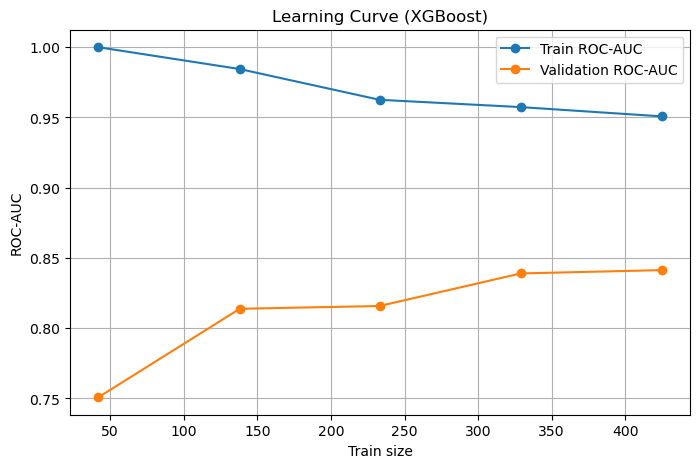

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 1) 데이터 로드
df = pd.read_pickle("diabetes_dropna.pkl")
print("데이터 로드:", df.shape)

# 2) X, y 분리
X = df.drop(columns="Outcome")
y = df["Outcome"]

# 3) Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# 4) XGBoost 파이프라인
pipe = Pipeline([
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42))
])

# 5) GridSearchCV: 과적합 완화용 파라미터
param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 4, 5],
    "xgb__learning_rate": [0.05, 0.1, 0.2],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("\n최적 파라미터:", gs.best_params_)
print("교차검증 ROC-AUC:", gs.best_score_)

# 6) 최적 모델 평가
best_model = gs.best_estimator_

y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:,1]
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

print("\n=== Train/Test Performance ===")
print(f"Train ACC: {accuracy_score(y_train, y_train_pred):.3f}, Train ROC-AUC: {roc_auc_score(y_train, y_train_proba):.3f}")
print(f"Test  ACC: {accuracy_score(y_test, y_test_pred):.3f}, Test  ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# 7) 학습곡선으로 과적합 시각화
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train ROC-AUC")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation ROC-AUC")
plt.xlabel("Train size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve (XGBoost)")
plt.legend()
plt.grid()
plt.show()


방법 2-1) 